In [1]:
# Introduction

In [2]:
# Business Understanding

In [3]:
# Objectives

In [4]:
# Data Understanding

In [5]:
## Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [6]:
## Load the data

train = pd.read_csv('Data/training_set_values.csv')
test = pd.read_csv('Data/test_set_values.csv')
train_labels = pd.read_csv('Data/training_set_labels.csv')

In [7]:
## Merge train set labels and train set values

train_merge = pd.merge(train, train_labels, on = 'id')

In [8]:
## Check data properties
### Training data

train_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [9]:
### testing data 

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [10]:
## Total number of functional and un-functional wells

train_merge.status_group.value_counts()

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

In [11]:
# Data Preparation

In [12]:
## Data Cleaning

### 1. Removing unnecessary columns

Several columns are first removed for various reasons.

- **id** is not a meaningful predictor
- **amount_tsh** is mostly blank
- **recorded_by** has only one unique value and therefore does not provide any variability
- **num_private** mostly has zeros as entries
- **scheme_name** is has alot of missing values (50%) and will therefore be dropped
- The following columns have similar information, which will lead to multicollinearity. So we will keep one of each:
    - **region, region_code**
    - **extraction_type_group, extraction_type_group, extraction_type_class**
    - **payment, payment_type**
    - **quantity, quantity_group**
    - **source, source_type**
    - **waterpoint_type, waterpoint_type_group**
    - **water_quality, quality_group**
    

In [13]:
#Checking for duplicates
print(train_merge.duplicated(subset = ['id']).value_counts())
print(test.duplicated(subset = ['id']).value_counts())

False    59400
Name: count, dtype: int64
False    14850
Name: count, dtype: int64


In [14]:
columns_to_remove = ['id','amount_tsh', 'recorded_by', 'num_private', 'region', 'quantity', 'quality_group', 'source_type', 'payment', 
          'waterpoint_type_group', 'scheme_name', 'extraction_type_group']

train_merge = train_merge.drop(columns_to_remove, axis =1)
test = test.drop(columns_to_remove, axis =1)

### 2. Changing the datatype

'date_recorded' has an **object** datatype, we will change this to **datetime** datatype

In [15]:
train_merge['date_recorded'] = pd.to_datetime(train_merge['date_recorded'])
test['date_recorded'] = pd.to_datetime(test['date_recorded'])

### 3.Imputing Missing Construction Year Values with the median

In [16]:
median_year = train_merge['construction_year'].median()
train_merge['construction_year'] = train_merge['construction_year'].replace(0, median_year)
test['construction_year'] = test['construction_year'].replace(0, median_year)

### 3. Creating a new column 'well_age'

In [17]:
train_merge['well_age'] = train_merge['date_recorded'].dt.year - train_merge['construction_year']
test['well_age'] = test['date_recorded'].dt.year - test['construction_year']

### 4. Filling missing values for specified categorical columns

In [18]:
#Checking for placeholder values
for col in train_merge.columns:
    print(col, '\n', train_merge[col].value_counts(normalize=True).head(), '\n\n')

date_recorded 
 date_recorded
2011-03-15    0.009630
2011-03-17    0.009394
2013-02-03    0.009192
2011-03-14    0.008754
2011-03-16    0.008636
Name: proportion, dtype: float64 


funder 
 funder
Government Of Tanzania    0.162904
Danida                    0.055843
Hesawa                    0.039489
Rwssp                     0.024640
World Bank                0.024192
Name: proportion, dtype: float64 


gps_height 
 gps_height
 0       0.344074
-15      0.001010
-16      0.000926
-13      0.000926
 1290    0.000875
Name: proportion, dtype: float64 


installer 
 installer
DWE           0.312171
Government    0.032738
RWE           0.021634
Commu         0.019015
DANIDA        0.018836
Name: proportion, dtype: float64 


longitude 
 longitude
0.000000     0.030505
37.375717    0.000034
38.340501    0.000034
39.086183    0.000034
33.005032    0.000034
Name: proportion, dtype: float64 


latitude 
 latitude
-2.000000e-08    0.030505
-6.985842e+00    0.000034
-6.980220e+00    0.000034
-2.

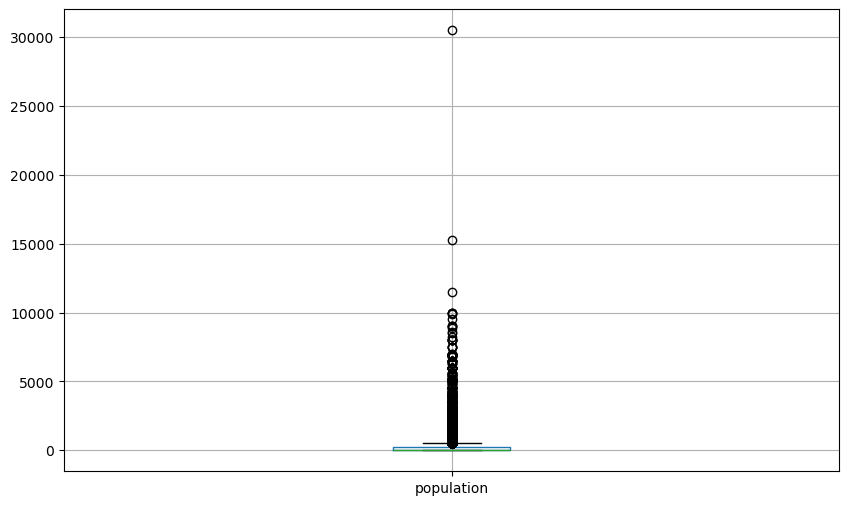

In [19]:
#Checking for outliers
train_merge[['population']].boxplot(figsize=(10, 6))
plt.show()

In [20]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_merge[['population']].quantile(0.25)
Q3 = train_merge[['population']].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_train = ((train_merge[['population']] < (Q1 - 1.5 * IQR)) | (train_merge[['population']] > (Q3 + 1.5 * IQR)))

print("Outliers detected using IQR method:")
print(outliers_train.sum())

Outliers detected using IQR method:
population    4383
dtype: int64


In [21]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = test[['population']].quantile(0.25)
Q3 = test[['population']].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_test = ((test[['population']] < (Q1 - 1.5 * IQR)) | (test[['population']] > (Q3 + 1.5 * IQR)))

print("Outliers detected using IQR method:")
print(outliers_test.sum())

Outliers detected using IQR method:
population    1070
dtype: int64


In [22]:
# Remove outliers from training data
train_merge = train_merge[~((train_merge[['population']] < (Q1 - 1.5 * IQR)) | 
                                           (train_merge[['population']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [23]:
# Remove outliers from test data
test = test[~((test[['population']] < (Q1 - 1.5 * IQR)) | 
                                           (test[['population']] > (Q3 + 1.5 * IQR))).any(axis=1)]

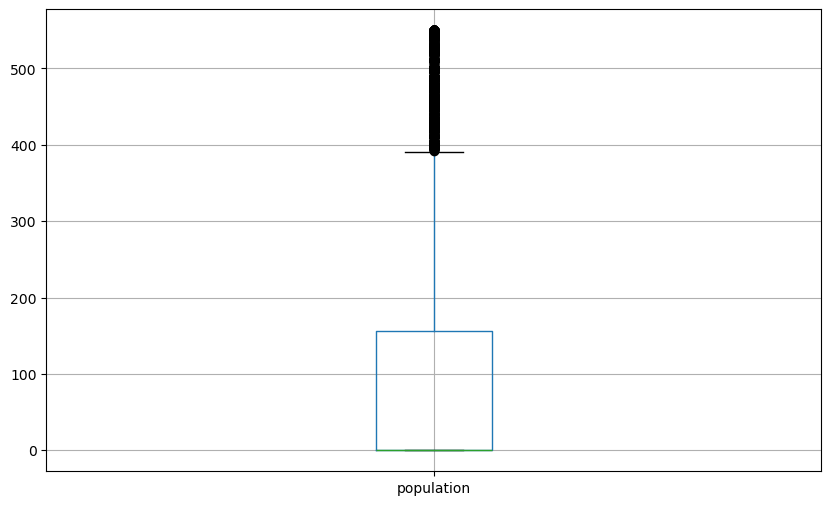

In [24]:
#Checking for outliers
train_merge[['population']].boxplot(figsize=(10, 6))
plt.show()

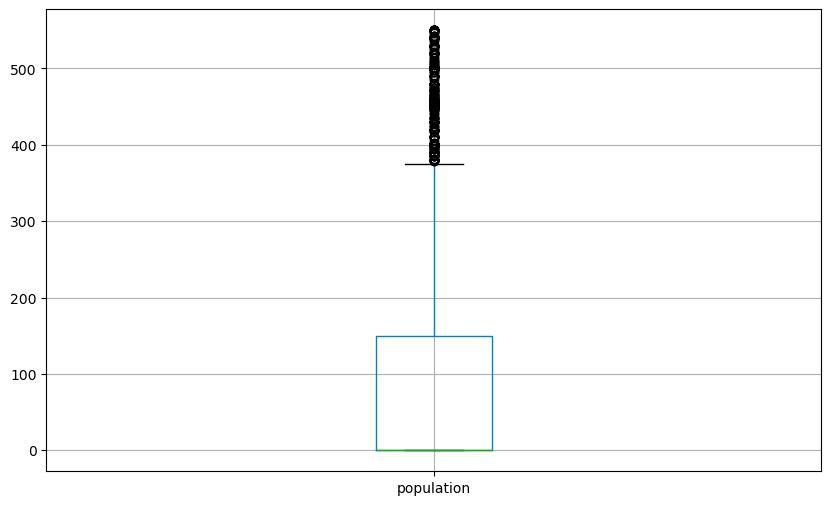

In [25]:
#Checking for outliers
test[['population']].boxplot(figsize=(10, 6))
plt.show()

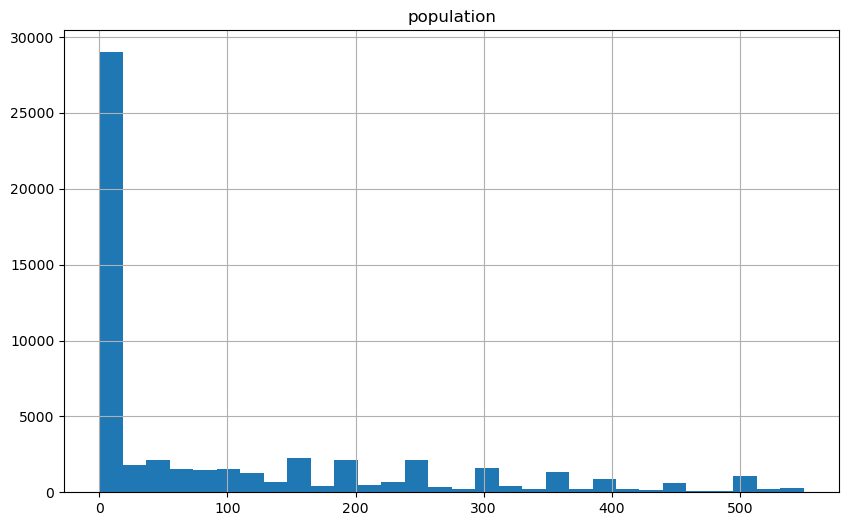

In [26]:
# Histograms for each feature
train_merge[['population']].hist(bins=30, figsize=(10, 6))
plt.show()

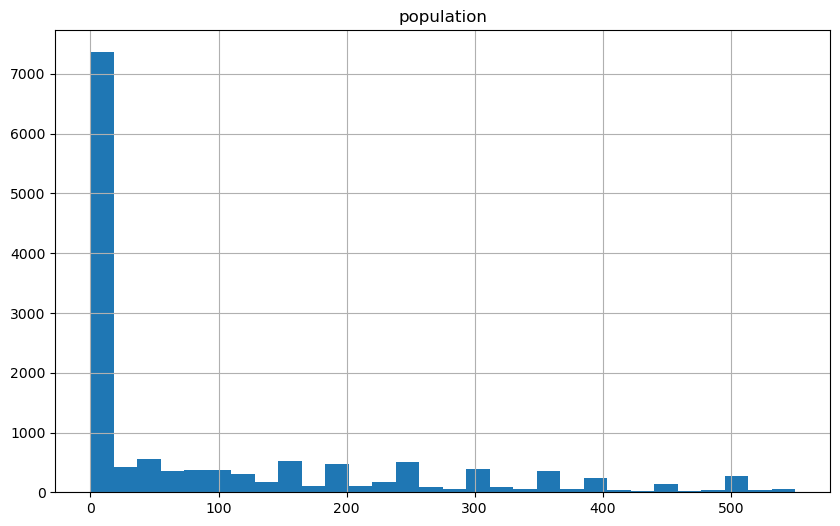

In [27]:
# Histograms for each feature
test[['population']].hist(bins=30, figsize=(10, 6))
plt.show()

In [28]:
# Check missing values

print(train_merge.isnull().sum())
print(test.isnull().sum())

date_recorded               0
funder                   3516
gps_height                  0
installer                3534
longitude                   0
latitude                    0
wpt_name                    2
basin                       0
subvillage                366
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3072
scheme_management        3395
permit                   2804
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source                      0
source_class                0
waterpoint_type             0
status_group                0
well_age                    0
dtype: int64
date_recorded              0
funder                   839
gps_height                 0


In [29]:
fill = {
    'funder': 'Unknown',
    'installer': 'Unknown',
    'scheme_management': 'Unknown',
    'wpt_name': 'Unknown',
    'subvillage': 'Unknown',
    'permit': 'False',
    'public_meeting': 'False'
}

train_merge.fillna(value = fill, inplace=True)
test.fillna(value = fill, inplace = True)

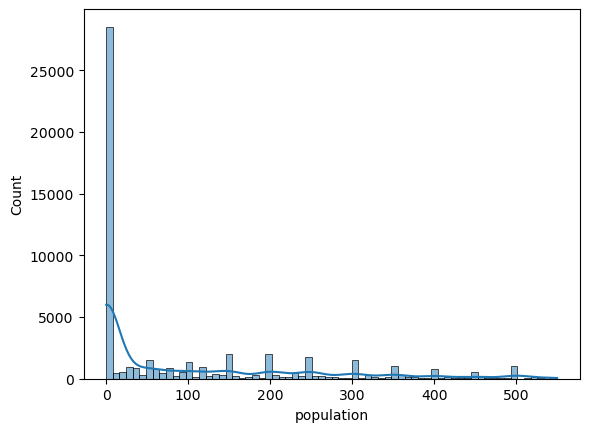

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train_merge['population'], kde=True)
plt.show()


In [31]:
## Define target variable and predictors

In [32]:
#y = train_merge['status_group']
#X = train_merge.drop (columns = 'status_group')

In [33]:
# Exploratory Data Analysis

In [34]:
# Modelling

In [35]:
# Evaluation

In [36]:
# Conclusion